<a href="https://colab.research.google.com/github/kasidejcha/net_rate/blob/main/net_rate_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [181]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from pandas import to_datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from statsmodels.tsa.api import VAR
from sklearn import preprocessing
# function for mape
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [44]:
train = pd.read_csv('/content/drive/My Drive/net_rate/Data/7.7/train.csv').drop('gmv_rate',axis=1)
val = pd.read_csv('/content/drive/My Drive/net_rate/Data/7.7/val.csv').drop('gmv_rate',axis=1)
val.tail()

,date,net_rate
25,2021-07-03,0.857004
26,2021-07-04,0.849715
27,2021-07-05,0.850116
28,2021-07-06,0.851735
29,2021-07-07,0.666483


In [45]:
# date cut
train = train[train['date']>='2020-07-01'].reset_index(drop=True)

In [46]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(train['net_rate'])

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

adfuller_test(train['net_rate'])

ADF Test Statistic : -11.282649980312575
p-value : 1.4434220786235808e-20
#Lags Used : 1
Number of Observations Used : 340
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


## Prophet single variable Forecasting

In [ ]:
# formatting for Prophet
train_prophet = train.copy().rename(columns={'date':'ds', 'net_rate': 'y'})
train_prophet['ds'] = to_datetime(train_prophet['ds'])

In [ ]:
model = Prophet()
model.fit(train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = model.make_future_dataframe(periods=len(val))
future.tail()

,ds
367,2021-07-03
368,2021-07-04
369,2021-07-05
370,2021-07-06
371,2021-07-07


In [ ]:
forecast1 = model.predict(future)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
367,2021-07-03,0.852815,0.802813,0.906429
368,2021-07-04,0.836731,0.782658,0.887269
369,2021-07-05,0.834270,0.782043,0.886408
370,2021-07-06,0.845007,0.794564,0.897081
371,2021-07-07,0.854581,0.801259,0.908607


In [ ]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(model, forecast1)

In [ ]:
result = val.copy()
result.rename(columns={'net_rate':'actual'},inplace=True)
result['forecast'] = forecast1['yhat'][-len(val):].reset_index(drop=True)
result.set_index('date',inplace=True)
result.index = to_datetime(result.index)

In [ ]:
# Metrics
forecast = result.copy()
# root mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])
rmse = sqrt(mse)

# mean absolute percent error
mape = MAPE(forecast['forecast'], forecast['actual'])

# mean absolute error
mae = mean_absolute_error(forecast['forecast'], forecast['actual'])

# mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])

# median absolute error
MDAE = np.median(abs(forecast['forecast']-forecast['actual']))

# median absolute percent error
MDAPE = np.median((np.abs(np.subtract(forecast['forecast'], forecast['actual'])/ forecast['actual']))) * 100

index=['mse','rmse','mae','mape','mdae','mdape']
metrics = pd.DataFrame([mse,rmse,mae,mape,MDAE,MDAPE],columns={'metrics'})
metrics.index = index
metrics

,metrics
mse,0.002311
rmse,0.048075
mae,0.030399
mape,3.569195
mdae,0.019179
mdape,2.213200


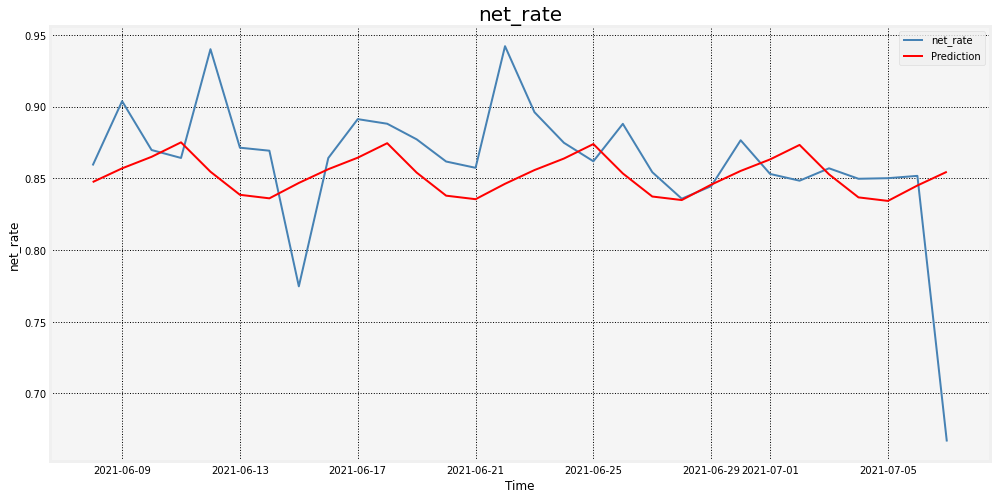

In [ ]:
# Plot Data
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 8) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color
plt.plot(forecast['actual'],label = 'net_rate',color="steelblue", linestyle="-", linewidth=2.0) # plot with set the line width,shape and color
plt.plot(forecast['forecast'], label = 'Prediction', color="Red", linewidth=2.0)
plt.legend()

plt.xlabel("Time")
plt.ylabel("net_rate")
plt.title("net_rate", fontsize = 20)
plt.grid(color="k", linestyle=":") # set grid and line shape

# plt.savefig('Daily cases.png')
plt.show()

## Prophet Multivariable Forecasting

In [462]:
# feature engineering
# log return: assume that prices are distributed log normally
eng = train.copy()
eng = eng.append(val).reset_index(drop=True)
print(eng.tail())
print('')
print('total len:', len(eng))
print('train len:', len(train))
print('val len:', len(val))
# https://quantivity.wordpress.com/2011/02/21/why-log-returns/

           date  net_rate
367  2021-07-03  0.857004
368  2021-07-04  0.849715
369  2021-07-05  0.850116
370  2021-07-06  0.851735
371  2021-07-07  0.666483

total len: 372
train len: 342
val len: 30


In [463]:
dday = []
for i in range(len(eng)):
    st = str(eng.date[i])
    if st[5:7] == st[8:10]:
        day = 1
        dday.append(day)
        continue
    if st[8:10] == '15':
        day = 1
        dday.append(day)
        continue
    else:
        day = 0
        dday.append(day)

eng['dday'] = dday
eng.tail()

,date,net_rate,dday
367,2021-07-03,0.857004,0
368,2021-07-04,0.849715,0
369,2021-07-05,0.850116,0
370,2021-07-06,0.851735,0
371,2021-07-07,0.666483,1


In [464]:
season=[]
summer = [3,4,5,6]
rain = [7,8,9,10]
winter = [11,12,1,2]

for i in range(len(eng)):
  st = str(eng.date[i])
  if int(st[5:7]) in summer:
    num_season = 0
    season.append(num_season)
    continue
  if int(st[5:7]) in rain:
    num_season = 1
    season.append(num_season)
    continue
  if int(st[5:7]) in winter:
    num_season = 2
    season.append(num_season)
    continue

eng['season'] = season
eng.tail()

,date,net_rate,dday,season
367,2021-07-03,0.857004,0,1
368,2021-07-04,0.849715,0,1
369,2021-07-05,0.850116,0,1
370,2021-07-06,0.851735,0,1
371,2021-07-07,0.666483,1,1


In [465]:
multi_eng = eng.copy()
multi_eng.rename(columns={'date':'ds','net_rate':'y'},inplace=True)
multi_eng.tail()

,ds,y,dday,season
367,2021-07-03,0.857004,0,1
368,2021-07-04,0.849715,0,1
369,2021-07-05,0.850116,0,1
370,2021-07-06,0.851735,0,1
371,2021-07-07,0.666483,1,1


In [466]:
# train & test split
multi_train = multi_eng[:-30]
multi_val = multi_eng[-30:]
multi_train.tail() #input train dataset

,ds,y,dday,season
337,2021-06-03,0.860099,0,0
338,2021-06-04,0.884038,0,0
339,2021-06-05,0.936399,0,0
340,2021-06-06,0.735210,1,0
341,2021-06-07,0.763073,0,0


In [467]:
multi_model = Prophet(interval_width=0.95)

In [468]:
multi_model.add_regressor('dday', standardize=False)
multi_model.add_regressor('season', standardize=False)

In [469]:
multi_model.fit(multi_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [470]:
multi_future = multi_model.make_future_dataframe(periods=len(multi_val))
multi_future.tail()

,ds
367,2021-07-03
368,2021-07-04
369,2021-07-05
370,2021-07-06
371,2021-07-07


In [471]:
# must know future value
multi_future['dday'] = multi_eng['dday']
multi_future['season'] = multi_eng['season']
multi_future.tail()

,ds,dday,season
367,2021-07-03,0,1
368,2021-07-04,0,1
369,2021-07-05,0,1
370,2021-07-06,0,1
371,2021-07-07,1,1


In [472]:
multi_forecast = multi_model.predict(multi_future)
multi_forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
367,2021-07-03,0.852395,0.787107,0.919176
368,2021-07-04,0.833414,0.756990,0.901088
369,2021-07-05,0.829310,0.758987,0.903388
370,2021-07-06,0.842968,0.774135,0.909696
371,2021-07-07,0.782324,0.715365,0.848766


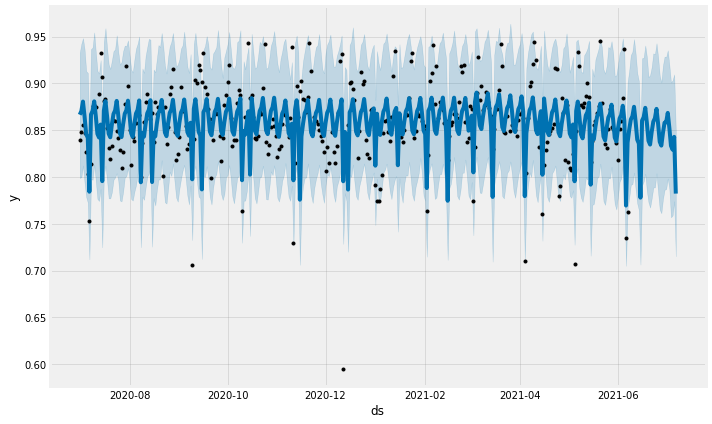

In [473]:
multi_fig = multi_model.plot(multi_forecast)

In [474]:
forecast = multi_forecast[['ds','yhat']][-30:].reset_index(drop=True)
forecast.rename(columns={'yhat':'forecast'}, inplace=True)
forecast['actual'] = val['net_rate']
forecast.set_index('ds',inplace=True)
forecast.tail()

,forecast,actual
ds,,
2021-07-03,0.852395,0.857004
2021-07-04,0.833414,0.849715
2021-07-05,0.829310,0.850116
2021-07-06,0.842968,0.851735
2021-07-07,0.782324,0.666483


In [475]:
# root mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])
rmse = sqrt(mse)

# mean absolute percent error
mape = MAPE(forecast['forecast'], forecast['actual'])

# mean absolute error
mae = mean_absolute_error(forecast['forecast'], forecast['actual'])

# mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])

# median absolute error
MDAE = np.median(abs(forecast['forecast']-forecast['actual']))

# median absolute percent error
MDAPE = np.median((np.abs(np.subtract(forecast['forecast'], forecast['actual'])/ forecast['actual']))) * 100

index=['mse','rmse','mae','mape','mdae','mdape']
metrics = pd.DataFrame([mse,rmse,mae,mape,MDAE,MDAPE],columns={'metrics'})
metrics.index = index
metrics

,metrics
mse,0.001326
rmse,0.036409
mae,0.024760
mape,2.947189
mdae,0.017525
mdape,2.023932


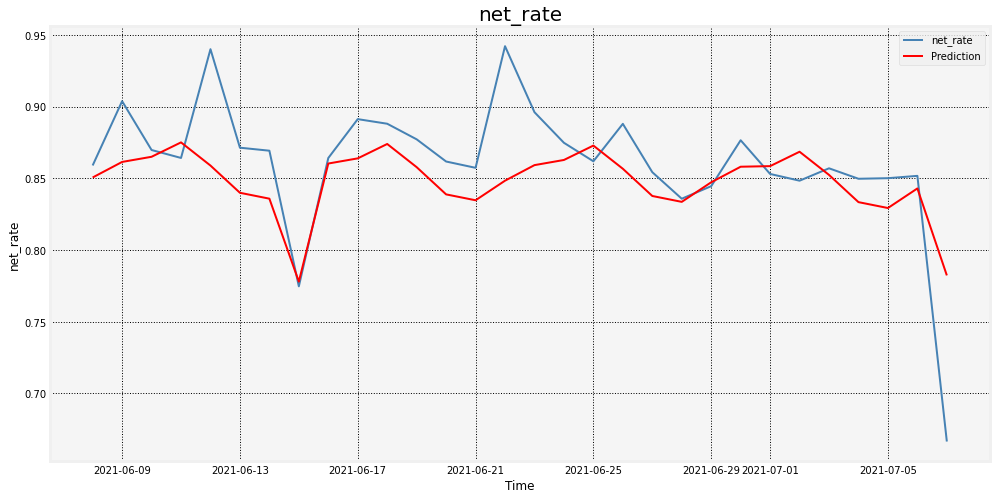

In [476]:
# Plot Data
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 8) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color
plt.plot(forecast['actual'],label = 'net_rate',color="steelblue", linestyle="-", linewidth=2.0) # plot with set the line width,shape and color
plt.plot(forecast['forecast'], label = 'Prediction', color="Red", linewidth=2.0)
plt.legend()

plt.xlabel("Time")
plt.ylabel("net_rate")
plt.title("net_rate", fontsize = 20)
plt.grid(color="k", linestyle=":") # set grid and line shape

# plt.savefig('Daily cases.png')
plt.show()

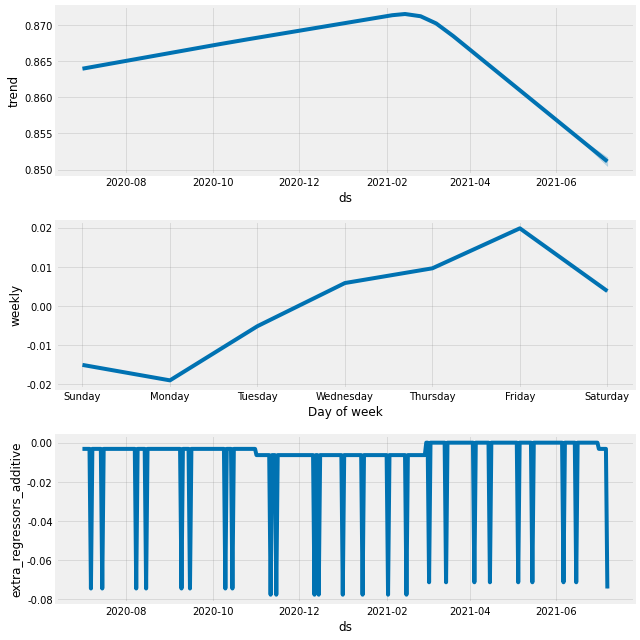

In [477]:
fig2 = multi_model.plot_components(multi_forecast)

In [478]:
from fbprophet.diagnostics import cross_validation, performance_metrics
# init = str(len(multi_train))+' days' # 341 days
init = 340 # decrease 1 day
hori = str(len(multi_val))+' days'
cv = cross_validation(model = multi_model, initial = init, horizon = hori)

INFO:fbprophet:Making 21 forecasts with cutoffs between 2020-07-12 00:00:00 and 2021-05-08 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 8.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.


In [479]:
performance_metrics(cv)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,0.003376,0.058106,0.041362,0.048916,0.038745,0.809524
1,4 days,0.003193,0.056509,0.039121,0.046685,0.033134,0.809524
2,5 days,0.002377,0.048751,0.033979,0.040648,0.028957,0.857143
3,6 days,0.001524,0.039036,0.029639,0.033894,0.027440,0.857143
4,7 days,0.001521,0.038996,0.030522,0.035419,0.030864,0.873016
5,8 days,0.001397,0.037378,0.030477,0.035800,0.032953,0.873016
6,9 days,0.001477,0.038433,0.032189,0.038405,0.034942,0.857143
7,10 days,0.001414,0.037608,0.030804,0.036954,0.028869,0.857143
8,11 days,0.001599,0.039987,0.032521,0.039236,0.028869,0.857143
9,12 days,0.001745,0.041769,0.033723,0.040491,0.028925,0.857143


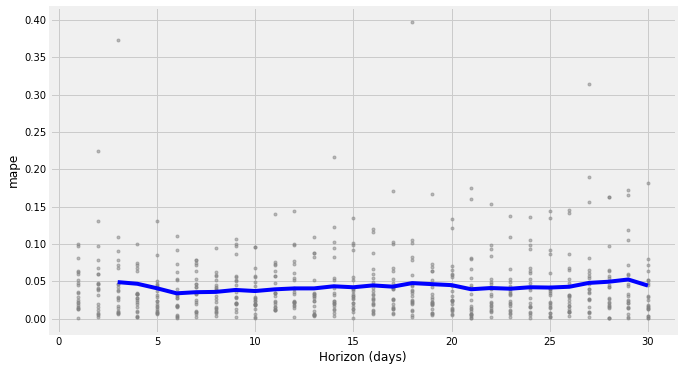

In [480]:
from fbprophet.plot import plot_cross_validation_metric

fig3 = plot_cross_validation_metric(cv,metric='mape')

## VAR Multivariable Forecasting

                 gmv_usd
grass_date              
2020-07-01  3.217051e+06
2020-07-02  3.047198e+06
2020-07-03  2.922012e+06
2020-07-04  2.500780e+06
2020-07-05  2.368386e+06
...                  ...
2021-07-03  3.452076e+06
2021-07-04  3.329569e+06
2021-07-05  3.755638e+06
2021-07-06  4.090176e+06
2021-07-07  1.630643e+07

[372 rows x 1 columns]



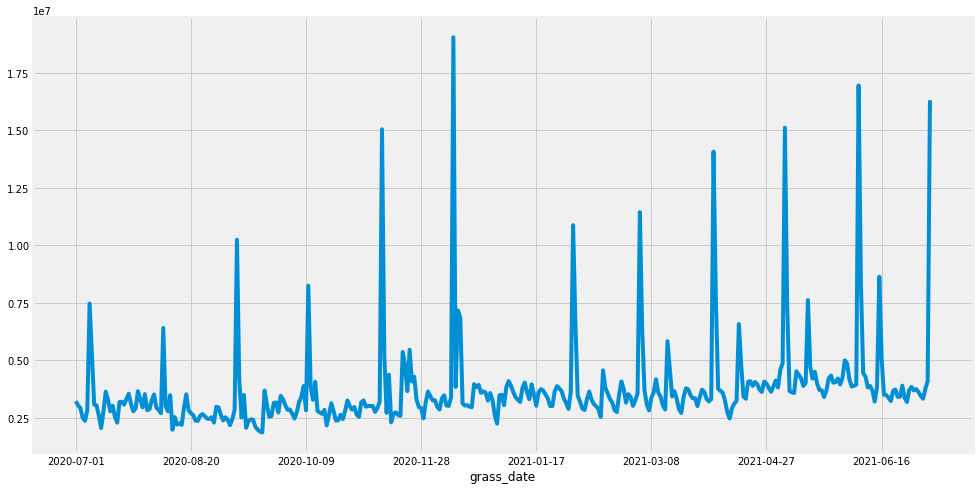

In [338]:
gmv_com_can = pd.read_csv('/content/drive/My Drive/net_rate/Data/7.7/gmv_order_mart_com&can.csv')
gmv_com_can = gmv_com_can[gmv_com_can.grass_date != '9999-01-01']
gmv_com_can.reset_index(inplace=True, drop=True)
gmv_com_can = gmv_com_can.set_index(['grass_date'])
gmv_com_can = gmv_com_can.sort_index()
gmv_com_can = gmv_com_can[gmv_com_can.index>= '2020-07-01']
gmv_com = gmv_com_can[gmv_com_can.order_fe_status == 'COMPLETED'].drop(['gmv','order_fe_status'],axis=1)
gmv_can = gmv_com_can[gmv_com_can.order_fe_status == 'CANCELLED'].drop(['gmv','order_fe_status'],axis=1)
print(gmv_can)
print('')
gmv_can.gmv_usd.plot()

In [390]:
# normalization
norm = preprocessing.MinMaxScaler()
gmv_com_norm = norm.fit_transform(gmv_com.to_numpy())
gmv_can_norm = norm.fit_transform(gmv_can.to_numpy())

eng_var = eng.copy()
eng_var = eng_var.set_index('date').drop(['month','season'],axis=1)
eng_var['gmv_com'] = gmv_com_norm
eng_var['gmv_can'] = gmv_can_norm
eng_var.gmv_com = eng_var.gmv_com.diff()
eng_var.gmv_can = eng_var.gmv_can.diff()
eng_var.dropna(inplace=True)
eng_var.index = to_datetime(eng_var.index)
eng_var.drop('dday',axis=1,inplace=True)
print('null: ', eng_var.isnull().values.any())
print(eng_var)
# eng_var.gmv_can.plot()

# VAR assumes stationary -> need to make data stationary
for i in range(len(eng_var.columns)):
  result = adfuller(eng_var[eng_var.columns[i]])
  # print(result)
  if result[1]>0.05:
    print('{} - series is not stationary'. format(eng_var.columns[i]))
  else:
    print('{} - series is stationary'. format(eng_var.columns[i]))

null:  False
            net_rate   gmv_com   gmv_can
date                                    
2020-07-02  0.848318 -0.008533 -0.009881
2020-07-03  0.855188  0.006401 -0.007283
2020-07-04  0.847392 -0.033160 -0.024506
2020-07-05  0.826917 -0.077230 -0.007702
2020-07-06  0.803467 -0.019361  0.026839
...              ...       ...       ...
2021-07-03  0.857004 -0.002914 -0.009958
2021-07-04  0.849715 -0.045441 -0.007127
2021-07-05  0.850116  0.003273  0.024787
2021-07-06  0.851735  0.013744  0.019462
2021-07-07  0.666483  0.095889  0.710698

[371 rows x 3 columns]
net_rate - series is stationary
gmv_com - series is stationary
gmv_can - series is stationary


In [426]:
# train val split
var_train = eng_var[:-30]
var_val = eng_var[-30:].drop(['gmv_com','gmv_can'],axis=1)
var_train.tail()

,net_rate,gmv_com,gmv_can
date,,,
2021-06-03,0.860099,0.010864,-0.018179
2021-06-04,0.884038,0.029016,0.001749
2021-06-05,0.936399,0.219715,0.003140
2021-06-06,0.735210,-0.287390,0.756571
2021-06-07,0.763073,0.009636,-0.499550


In [427]:
var_model = VAR(var_train, freq='1D')

In [428]:
var_model.select_order(50).summary()

,AIC,BIC,FPE,HQIC
0,-15.27,-15.23,2.341e-07,-15.25
1,-17.40,-17.25,2.781e-08,-17.34
2,-17.59,-17.32*,2.305e-08,-17.48
3,-17.62,-17.25,2.217e-08,-17.47
4,-17.68,-17.19,2.091e-08,-17.49*
5,-17.69,-17.09,2.071e-08,-17.45
6,-17.69,-16.97,2.070e-08*,-17.41
7,-17.69,-16.86,2.076e-08,-17.36
8,-17.69,-16.74,2.078e-08,-17.31
9,-17.69,-16.63,2.082e-08,-17.26


In [435]:
var_model = VAR(var_train, freq='1D')
lag = 16
var_model = var_model.fit(lag) # lag with lowest AIC and BIC is 2

In [436]:
var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 19, Jul, 2021
Time:                     08:59:58
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -16.1706
Nobs:                     325.000    HQIC:                  -17.1990
Log likelihood:           1669.36    FPE:                1.72564e-08
AIC:                     -17.8820    Det(Omega_mle):     1.13236e-08
--------------------------------------------------------------------
Results for equation net_rate
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.266930         0.220319            1.212           0.226
L1.net_rate          0.307846         0.157253            1.958           0.050
L1.gmv_com           0.027978         0.062339            0.4

In [437]:
lag = var_model.k_ar 
val_results = var_model.forecast(var_train.values[-lag:], steps=30)
val_results

array([[ 8.43515001e-01,  1.09887742e-01, -1.79973528e-01],
       [ 9.08657977e-01,  2.08500918e-01, -1.04030756e-02],
       [ 8.90495178e-01, -1.07360073e-01,  9.42964401e-03],
       [ 9.29830252e-01,  5.19217172e-02, -8.46830089e-02],
       [ 9.16496271e-01, -3.97568844e-02,  3.76209414e-02],
       [ 8.52186632e-01, -1.34376754e-01,  1.38559652e-01],
       [ 8.73492137e-01, -1.75061194e-02, -1.89041692e-01],
       [ 8.60598869e-01,  2.84069318e-03,  9.77049978e-02],
       [ 8.68243323e-01,  4.08874850e-02,  3.26413238e-02],
       [ 8.55373856e-01, -1.36846176e-02,  2.82616301e-02],
       [ 8.61707030e-01, -2.80102531e-04,  1.25432304e-02],
       [ 8.82845727e-01,  2.15016253e-02, -7.97093791e-02],
       [ 8.39787293e-01, -8.84970636e-02,  5.04932816e-02],
       [ 8.34184521e-01,  5.92681595e-04,  2.26140307e-02],
       [ 8.60449780e-01,  1.03676983e-01, -7.83557299e-02],
       [ 8.65167827e-01, -2.43689976e-02,  3.27410792e-02],
       [ 8.74963973e-01,  3.42981366e-02

In [438]:
forecast=var_val.copy()
forecast['forecast'] = val_results[:,0]
# forecast.drop('dday',axis=1,inplace=True)
forecast.rename(columns={'net_rate':'actual'}, inplace=True)
forecast.tail()

,actual,forecast
date,,
2021-07-03,0.857004,0.867432
2021-07-04,0.849715,0.850072
2021-07-05,0.850116,0.851855
2021-07-06,0.851735,0.860749
2021-07-07,0.666483,0.867665


In [439]:
mse = mean_squared_error(forecast['forecast'], forecast['actual'])
rmse = sqrt(mse)

# mean absolute percent error
mape = MAPE(forecast['forecast'], forecast['actual'])

# mean absolute error
mae = mean_absolute_error(forecast['forecast'], forecast['actual'])

# mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])

# median absolute error
MDAE = np.median(abs(forecast['forecast']-forecast['actual']))

# median absolute percent error
MDAPE = np.median((np.abs(np.subtract(forecast['forecast'], forecast['actual'])/ forecast['actual']))) * 100

index=['mse','rmse','mae','mape','mdae','mdape']
metrics = pd.DataFrame([mse,rmse,mae,mape,MDAE,MDAPE],columns={'metrics'})
metrics.index = index
metrics

,metrics
mse,0.002237
rmse,0.047293
mae,0.027411
mape,3.157807
mdae,0.019385
mdape,2.248735


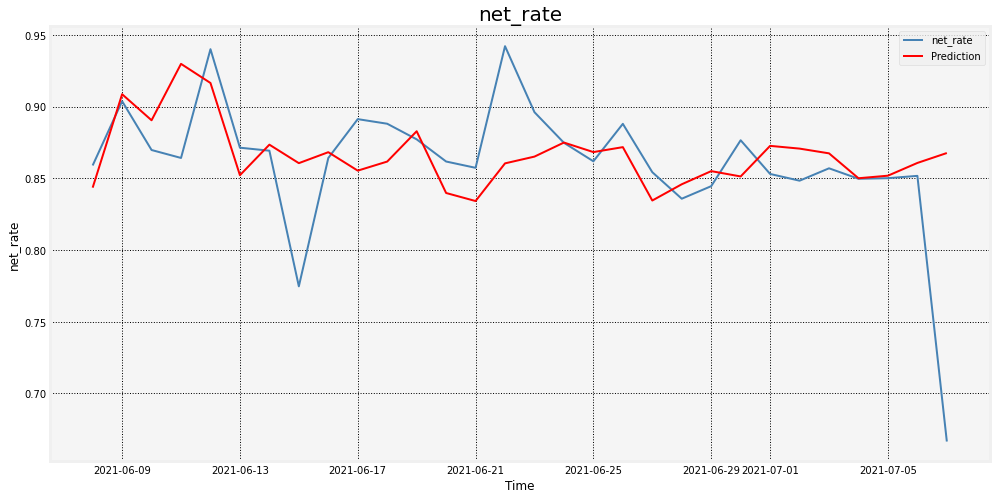

In [440]:
# Plot Data
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 8) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color
plt.plot(forecast['actual'],label = 'net_rate',color="steelblue", linestyle="-", linewidth=2.0) # plot with set the line width,shape and color
plt.plot(forecast['forecast'], label = 'Prediction', color="Red", linewidth=2.0)
plt.legend()

plt.xlabel("Time")
plt.ylabel("net_rate")
plt.title("net_rate", fontsize = 20)
plt.grid(color="k", linestyle=":") # set grid and line shape

# plt.savefig('Daily cases.png')
plt.show()